# hs-code-nlp-classifier-cl

## Arquitectura

```text
    Entrada: descripción del producto
                ↓
[Filtro IN/OUT — BERT binario compartido]
                ↓
   ┌───────────────────────────────┐
   ↓                               ↓
[SVM multiclase]           [BERT multiclase]
        ↓                          ↓
   Código HS                  Código HS
        ↓                          ↓
            [Revisión Expeta]
```

### Clasificación multiclase

In [ ]:
TEST_MODE = True


#### Dataset multiclase para la capa IN

In [ ]:

# Cargar clases objetivo desde el artefacto generado
path_clases_in = Path(DIR_LOG) / ("clases_ins_test.csv" if TEST_MODE else "clases_ins.csv")
clases_objetivo = pd.read_csv(path_clases_in)["clases_objetivo"].astype(str).tolist()
clases_set = set(clases_objetivo)

df_mc = df_in_top_k.copy()
df_mc[COL_CODE] = df_mc[COL_CODE].astype(str).str.strip()
df_mc = df_mc[df_mc[COL_CODE].isin(clases_set)].copy()

# Etiqueta multiclase: el código HS dentro del set objetivo
df_mc["label_code"] = df_mc[COL_CODE].astype(str)

print("[INFO] registros IN (multiclase):", len(df_mc))
print("[INFO] clases:", df_mc["label_code"].nunique())
print(df_mc["label_code"].value_counts().head(10))


[INFO] registros IN (multiclase): 2180000
[INFO] clases: 50
label_code
30061059    126200
90213990    124172
90189089    109399
33041000    107284
84439990     96314
33042000     81872
84314320     75728
33049990     74860
33059090     70094
84733000     57488
Name: count, dtype: int64


#### Split estratificado por código HS

In [ ]:
SEED = int(SEED)

# (Opcional) cap por clase para limitar tamaño y evitar sesgos extremos
N_PER_CLASS_MC = 2000
df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(
    lambda x: x.sample(min(len(x), N_PER_CLASS_MC), random_state=SEED)
).reset_index(drop=True)

# Split train/val/test estratificado por label_code
df_trainval, df_test_mc = train_test_split(
    df_mc_bal,
    test_size=0.20,
    stratify=df_mc_bal["label_code"],
    random_state=SEED
)
df_train_mc, df_val_mc = train_test_split(
    df_trainval,
    test_size=0.10 / 0.80,  # val=10% total
    stratify=df_trainval["label_code"],
    random_state=SEED
)

print("[INFO] train_mc:", len(df_train_mc), "| val_mc:", len(df_val_mc), "| test_mc:", len(df_test_mc))
print("[INFO] clases train:", df_train_mc["label_code"].nunique())


/tmp/ipython-input-3385288075.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mc_bal = df_mc.groupby("label_code", group_keys=False).apply(


[INFO] train_mc: 70000 | val_mc: 10000 | test_mc: 20000
[INFO] clases train: 50


### Modelo BERT multiclase

#### Pámetros

In [ ]:
# Base model
BERT_MODEL_NAME_MC = MODEL_NAME
MAX_LENGTH_MC = 64

# Entrenamiento
EPOCHS_MC = 2
LR_MC = 2e-5
WEIGHT_DECAY_MC = 0.01
WARMUP_RATIO_MC = 0.06

# Batch (ajustables)
BATCH_TRAIN_MC = 16
BATCH_EVAL_MC  = 32
GRAD_ACC_MC    = 2

# Workers
NUM_WORKERS_MC = 4

# Logging
LOGGING_STEPS_MC = 100

# Directorios
TMP_OUT_DIR = Path(DIR_MODELS) / ("tmp_multiclass_test" if TEST_MODE else "tmp_multiclass")
BERT_MC_DIR = Path(DIR_MODELS) / ("bert_multiclass_test" if TEST_MODE else "bert_multiclass_final")
BERT_MC_DIR.mkdir(parents=True, exist_ok=True)

if TEST_MODE:
    EPOCHS_MC = 1
    BATCH_TRAIN_MC = 32 # Aumentado para acelerar más en TEST_MODE
    BATCH_EVAL_MC  = 32
    GRAD_ACC_MC    = 2
    N_PER_CLASS_MC = 200 # Reducido para un dataset multiclase de prueba más pequeño

print("[INFO] BERT MULTICLASS CONFIG")
print(" - TEST_MODE:", TEST_MODE)
print(" - BERT_MODEL_NAME_MC:", BERT_MODEL_NAME_MC)
print(" - MAX_LENGTH_MC:", MAX_LENGTH_MC)
print(" - EPOCHS_MC:", EPOCHS_MC)
print(" - LR_MC:", LR_MC)
print(" - BATCH_TRAIN_MC:", BATCH_TRAIN_MC)
print(" - GRAD_ACC_MC:", GRAD_ACC_MC)
print(" - BATCH_EVAL_MC:", BATCH_EVAL_MC)
print(" - OUT_DIR:", BERT_MC_DIR)
print(" - TMP_OUT_DIR:", TMP_OUT_DIR)

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("[INFO] device:", device)


[INFO] BERT MULTICLASS CONFIG
 - TEST_MODE: True
 - BERT_MODEL_NAME_MC: bert-base-multilingual-cased
 - MAX_LENGTH_MC: 64
 - EPOCHS_MC: 1
 - LR_MC: 2e-05
 - BATCH_TRAIN_MC: 32
 - GRAD_ACC_MC: 2
 - BATCH_EVAL_MC: 32
 - OUT_DIR: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test
 - TMP_OUT_DIR: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/tmp_multiclass_test
[INFO] device: cuda


#### Dataset

In [ ]:
# Checks de datos
assert "label_code" in df_train_mc.columns, "Falta columna label_code en df_train_mc"
assert COL_TEXT in df_train_mc.columns, f"Falta columna de texto {COL_TEXT}"

print("[INFO] tamaños:")
print(" - train:", len(df_train_mc))
print(" - val  :", len(df_val_mc))
print(" - test :", len(df_test_mc))

print("[INFO] ejemplos de texto (train):")
print(df_train_mc[COL_TEXT].astype(str).head(2).tolist())

print("[INFO] distribución de clases (train) top10:")
print(df_train_mc["label_code"].astype(str).value_counts().head(10))

# LabelEncoder (fit SOLO en train)
le = LabelEncoder()
le.fit(df_train_mc["label_code"].astype(str))
K = len(le.classes_)
print("[INFO] num_labels (K):", K)

# Si K es demasiado grande para su escenario test, puede limitarlo opcionalmente:
# (recomendación: no tocar aquí salvo que quiera reducir alcance)


[INFO] tamaños:
 - train: 70000
 - val  : 10000
 - test : 20000
[INFO] ejemplos de texto (train):
['SANDVIK-F; DE ACERO; PARA MAQUINA QUEBRANTADORA DE MINERALES SOLIDOS', 'URBAN; LUMINOUS; PREPARACION PARA EL MAQUILLAJE']
[INFO] distribución de clases (train) top10:
label_code
84314900    1400
33049100    1400
64041100    1400
85176210    1400
38221900    1400
84139100    1400
39269090    1400
85044000    1400
33059020    1400
64021900    1400
Name: count, dtype: int64
[INFO] num_labels (K): 50


#### Tokenizer

In [ ]:
# Tokenizer + encoding
brt_tokenizer_mc = AutoTokenizer.from_pretrained(BERT_MODEL_NAME_MC, use_fast=True)

def encode_df_multiclass(df: pd.DataFrame, name: str):
    t0 = time.time()
    texts = df[COL_TEXT].fillna("").astype(str).map(preprocesar_texto).tolist()
    y = le.transform(df["label_code"].astype(str))
    empty = sum(len(x.strip()) == 0 for x in texts)
    print(f"[INFO] encode_df({name}) -> n={len(texts)} | empty_texts={empty} | time={time.time()-t0:.1f}s")
    return texts, y

BERT_train_texts, BERT_train_y = encode_df_multiclass(df_train_mc, "train")
BERT_val_texts,BERT_val_y = encode_df_multiclass(df_val_mc,   "val")
BERT_test_texts,BERT_test_y = encode_df_multiclass(df_test_mc,  "test")


[INFO] encode_df(train) -> n=70000 | empty_texts=0 | time=0.1s
[INFO] encode_df(val) -> n=10000 | empty_texts=0 | time=0.0s
[INFO] encode_df(test) -> n=20000 | empty_texts=0 | time=0.0s


#### Padding Dinámico

In [ ]:

# Dataset + collator
class HSMultiDataset(Dataset):
    _name = None # Workaround for AttributeError with Trainer and custom torch.utils.data.Dataset

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            # Handle batched indexing by DataLoader
            texts = [self.texts[i] for i in idx]
            labels = [int(self.labels[i]) for i in idx]
            enc = self.tok(
                texts,
                truncation=True,
                max_length=self.max_length,
                padding=False
            )
            enc["labels"] = labels
            return enc

        # Handle single item indexing
        text = self.texts[idx]
        label = int(self.labels[idx])
        enc = self.tok(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False
        )
        enc["labels"] = label
        return enc

brt_train_mc_ds = HSMultiDataset(BERT_train_texts, BERT_train_y, brt_tokenizer_mc, MAX_LENGTH_MC)
brt_val_mc_ds = HSMultiDataset(BERT_val_texts, BERT_val_y, brt_tokenizer_mc, MAX_LENGTH_MC)
brt_test_mc_ds = HSMultiDataset(BERT_test_texts, BERT_test_y, brt_tokenizer_mc, MAX_LENGTH_MC)

data_collator_mc = DataCollatorWithPadding(
    tokenizer=brt_tokenizer_mc,
    pad_to_multiple_of=8
)

print("[INFO] datasets construidos:")
print(" - train_mc_ds:", len(brt_train_mc_ds))
print(" - val_mc_ds  :", len(brt_val_mc_ds))
print(" - test_mc_ds :", len(brt_test_mc_ds))


[INFO] datasets construidos:
 - train_mc_ds: 70000
 - val_mc_ds  : 10000
 - test_mc_ds : 20000


#### Métricas para BERT multiclase

In [ ]:
# Métricas
def compute_metrics_mc(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

print("[INFO] compute_metrics_mc listo (accuracy + macro_f1)")


[INFO] compute_metrics_mc listo (accuracy + macro_f1)


#### Modelo + TrainingArguments

In [ ]:
# Modelo
BERT_model_mc = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME_MC,
    num_labels=K
)

brt_training_args_mc = TrainingArguments(
    output_dir=str(TMP_OUT_DIR),

    group_by_length=False, # Desactivado para evitar AttributeError con custom torch.utils.data.Dataset
    length_column_name="length",

    eval_strategy="no",
    save_strategy="no",

    logging_strategy="steps",
    logging_steps=LOGGING_STEPS_MC,

    per_device_train_batch_size=BATCH_TRAIN_MC,
    gradient_accumulation_steps=GRAD_ACC_MC,
    per_device_eval_batch_size=BATCH_EVAL_MC,

    num_train_epochs=EPOCHS_MC,
    learning_rate=LR_MC,
    weight_decay=WEIGHT_DECAY_MC,
    warmup_ratio=WARMUP_RATIO_MC,

    fp16=True,
    bf16=False,

    dataloader_num_workers=NUM_WORKERS_MC,
    remove_unused_columns=False,
    report_to="none",
    seed=SEED,
    disable_tqdm=False,
)

print("[INFO] TrainingArguments configurados")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] TrainingArguments configurados


#### Entrenamiento

In [ ]:
# Trainer
BERT_trainer_mc = Trainer(
    model=BERT_model_mc,
    args=brt_training_args_mc,
    train_dataset=brt_train_mc_ds,
    eval_dataset=brt_val_mc_ds,
    tokenizer=brt_tokenizer_mc,
    data_collator=data_collator_mc,
    compute_metrics=compute_metrics_mc,
)

MODEL_MARKER = BERT_MC_DIR / "config.json"

if MODEL_MARKER.exists() and not TEST_MODE:
    print("[INFO] Modelo multiclase ya existe, cargando desde:", BERT_MC_DIR)
    brt_tokenizer_mc = AutoTokenizer.from_pretrained(str(BERT_MC_DIR), use_fast=True)
    BERT_model_mc = AutoModelForSequenceClassification.from_pretrained(str(BERT_MC_DIR))
    BERT_trainer_mc.model = BERT_model_mc
else:
    print("[INFO] Iniciando entrenamiento BERT multiclase...")
    print(" - epochs:", EPOCHS_MC)
    print(" - batch_train:", BATCH_TRAIN_MC)
    print(" - grad_acc:", GRAD_ACC_MC)
    print(" - batch_eval:", BATCH_EVAL_MC)
    print(" - lr:", LR_MC)
    print(" - num_labels:", K)

    t0 = time.time()
    train_out_mc = BERT_trainer_mc.train()
    dt = time.time() - t0

    print("[OK] Entrenamiento completado")
    print("[INFO] tiempo (s):", round(dt, 2))
    print("[INFO] métricas train:", train_out_mc.metrics)

    # Guardar artefactos
    BERT_trainer_mc.save_model(str(BERT_MC_DIR))
    brt_tokenizer_mc.save_pretrained(str(BERT_MC_DIR))

    with open(BERT_MC_DIR / ("train_output_test.json" if TEST_MODE else "train_output.json"), "w", encoding="utf-8") as f:
        json.dump(train_out_mc.metrics, f, ensure_ascii=False, indent=2)

    with open(BERT_MC_DIR / ("label_encoder_classes_test.json" if TEST_MODE else "label_encoder_classes.json"), "w", encoding="utf-8") as f:
        json.dump(le.classes_.tolist(), f, ensure_ascii=False, indent=2)

    print("[OK] Artefactos guardados en:", BERT_MC_DIR)


/tmp/ipython-input-1647132407.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  BERT_trainer_mc = Trainer(


[INFO] Iniciando entrenamiento BERT multiclase...
 - epochs: 1
 - batch_train: 32
 - grad_acc: 2
 - batch_eval: 32
 - lr: 2e-05
 - num_labels: 50


Step,Training Loss
100,3.684900
200,2.584800
300,1.823000
400,1.442600
500,1.240700
600,1.095100
700,1.058300
800,0.984700
900,0.939600
1000,0.915900


[OK] Entrenamiento completado
[INFO] tiempo (s): 214.68
[INFO] métricas train: {'train_runtime': 214.2175, 'train_samples_per_second': 326.771, 'train_steps_per_second': 5.107, 'total_flos': 1988529100151808.0, 'train_loss': 1.5187336016834545, 'epoch': 1.0}
[OK] Artefactos guardados en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test


#### Evaluación

In [245]:
# Evaluación final
print("[INFO] Evaluando en VAL...")
brt_val_pred = BERT_trainer_mc.predict(brt_val_mc_ds)
brt_val_metrics = compute_metrics_mc((brt_val_pred.predictions, brt_val_pred.label_ids))
print("[BERT-MC] VAL metrics:", brt_val_metrics)





[INFO] Evaluando en VAL...


[BERT-MC] VAL metrics: {'accuracy': 0.7573, 'macro_f1': 0.7511791954981497}


In [ ]:
print("[INFO] Evaluando en TEST...")
brt_test_pred = BERT_trainer_mc.predict(brt_test_mc_ds)
brt_test_metrics = compute_metrics_mc((brt_test_pred.predictions, brt_test_pred.label_ids))
print("[BERT-MC] TEST metrics:", brt_test_metrics)


[INFO] Evaluando en TEST...


[BERT-MC] TEST metrics: {'accuracy': 0.7603, 'macro_f1': 0.7550597870724238}


In [ ]:
# Reporte detallado (opcional, puede ser largo si K grande)
brt_preds_test = np.argmax(brt_test_pred.predictions, axis=1)
brt_y_true_test = brt_test_pred.label_ids

# Convertir a etiquetas HS para reporte legible
brt_y_true_hs = le.inverse_transform(brt_y_true_test)
brt_y_pred_hs = le.inverse_transform(brt_preds_test)

print("[INFO] Classification report (TEST):")
print(classification_report(brt_y_true_hs, brt_y_pred_hs, digits=4))


[INFO] Classification report (TEST):
              precision    recall  f1-score   support

    30061059     0.9578    0.9650    0.9614       400
    33030010     0.6036    0.8300    0.6989       400
    33030020     0.7063    0.4750    0.5680       400
    33041000     0.9010    0.8650    0.8827       400
    33042000     0.9536    0.8225    0.8832       400
    33043020     0.9872    0.9625    0.9747       400
    33049100     0.5687    0.8900    0.6940       400
    33049980     0.7554    0.7875    0.7711       400
    33049990     0.6038    0.3200    0.4183       400
    33051010     0.9501    0.8100    0.8745       400
    33059020     0.5416    0.7975    0.6451       400
    33059030     0.8352    0.9375    0.8834       400
    33059090     0.6745    0.3575    0.4673       400
    38221900     0.9330    0.9750    0.9535       400
    39269090     0.8234    0.7925    0.8076       400
    40169390     0.9453    0.9075    0.9260       400
    42029220     0.9695    0.9550    0.9622 

##### Matriz de Confusión

[INFO] Matriz de Confusión para BERT Multiclase (primeras 10x10 clases):


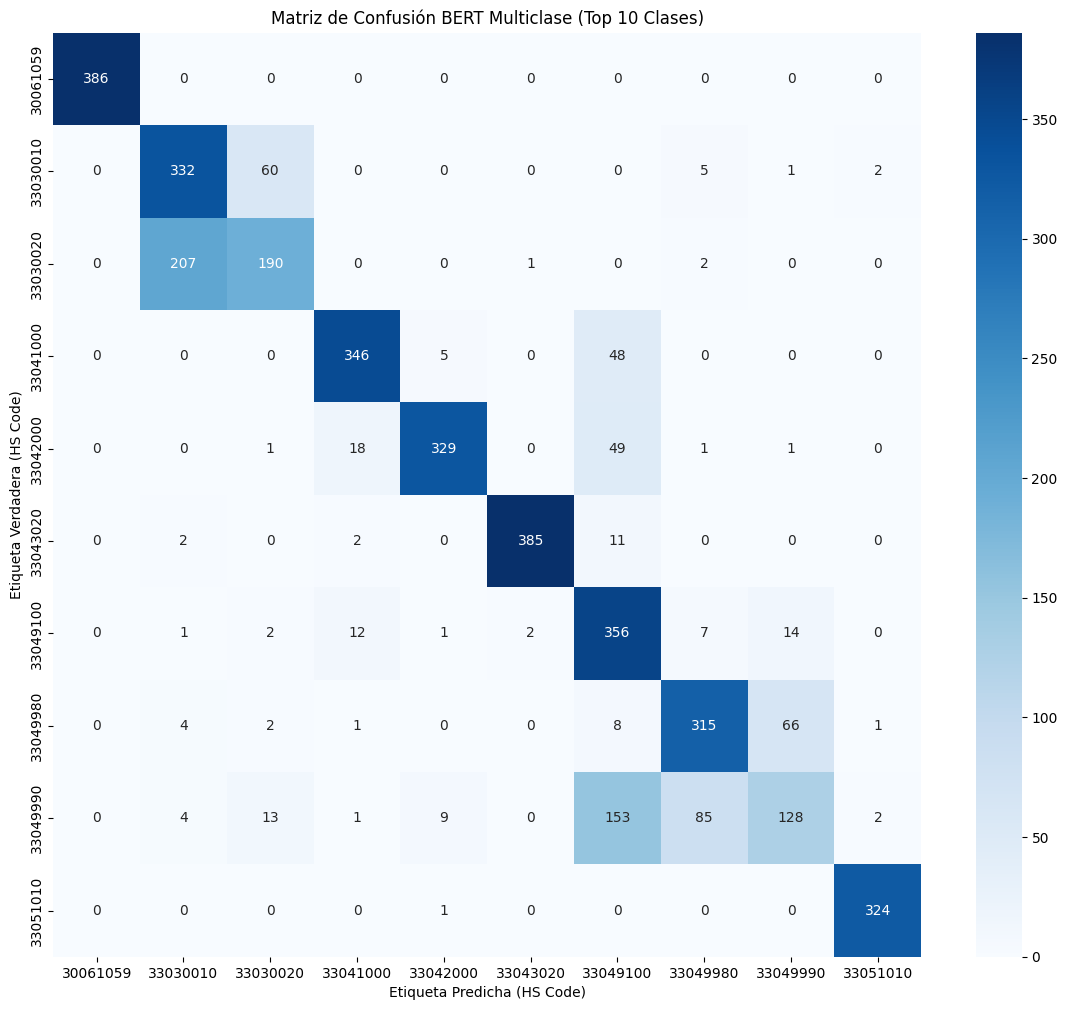

In [ ]:
# Calcular la matriz de confusión
# Se usa 'le.classes_' para asegurar que las etiquetas estén en el orden correcto.
brt_cm_bert_mc = confusion_matrix(brt_y_true_hs, brt_y_pred_hs, labels=le.classes_)

print("[INFO] Matriz de Confusión para BERT Multiclase (primeras 10x10 clases):")
# Para un alto número de clases, mostrar solo una parte o sin anotaciones para no saturar
plt.figure(figsize=(14, 12))
sns.heatmap(brt_cm_bert_mc[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_[:10], yticklabels=le.classes_[:10])
plt.xlabel('Etiqueta Predicha (HS Code)')
plt.ylabel('Etiqueta Verdadera (HS Code)')
plt.title('Matriz de Confusión BERT Multiclase (Top 10 Clases)')
plt.show()


##### Backup

In [ ]:

# Guardar métricas finales
brt_metrics_path = BERT_MC_DIR / ("eval_metrics_test.json" if TEST_MODE else "eval_metrics.json")
payload = {
    "val": brt_val_metrics,
    "test": brt_test_metrics,
    "K": int(K),
    "model_name": BERT_MODEL_NAME_MC,
    "max_length": int(MAX_LENGTH_MC),
    "test_mode": bool(TEST_MODE),
}

with open(brt_metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print("[OK] Métricas guardadas en:", metrics_path)


[OK] Métricas guardadas en: /content/drive/MyDrive/hs-code-nlp-classifier-cl/models/bert_multiclass_test/eval_metrics_test.json


### Inferencia Arquitectura Completa

In [ ]:

# Cargar τ
INOUT_DIR = Path(DIR_MODELS) / "bert_inout_ckpt_final"
with open(INOUT_DIR / "thresholds.json", "r", encoding="utf-8") as f:
    th = json.load(f)
TAU_IN = float(th["tau_in"])

def predict_inout_proba(text: str) -> float:
    text = preprocesar_texto(text)
    enc = tokenizer(text, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    proba_in = torch.softmax(logits, dim=-1).cpu().numpy()[0, 1]
    return float(proba_in)

def route_predict(text: str, head: str = "svm"):
    proba_in = predict_inout_proba(text)
    is_in = (proba_in >= TAU_IN)

    if not is_in:
        return {
            "route": "OUT",
            "hs_code": None,
            "proba_in": proba_in
        }

    # IN: aplicar head
    if head == "svm":
        hs = svm_clf.predict([preprocesar_texto(text)])[0]
        return {"route": "IN", "hs_code": hs, "proba_in": proba_in, "head": "svm"}

    if head == "bert":
        t = preprocesar_texto(text)
        enc = brt_tokenizer_mc(t, truncation=True, max_length=MAX_LENGTH_MC, return_tensors="pt")
        enc = {k: v.to("cuda") for k, v in enc.items()}  # en Colab
        with torch.no_grad():
            logits = BERT_model_mc(**enc).logits
        pred = int(torch.argmax(logits, dim=-1).cpu().numpy()[0])
        hs = le.classes_[pred]
        return {"route": "IN", "hs_code": hs, "proba_in": proba_in, "head": "bert"}

    raise ValueError("head debe ser 'svm' o 'bert'")


Test

In [254]:
# dataset fuente
df_src = df_test_mc if "df_test_mc" in globals() else df_val_mc

assert COL_TEXT in df_src.columns, f"Falta COL_TEXT={COL_TEXT} en df_src"
assert "label_code" in df_src.columns, "Falta columna 'label_code' en df_src (ajuste el nombre si es distinto)"

# Seleccionar fila aleatoria
row = df_src.sample(1, random_state=None).iloc[0]
sample_text = str(row[COL_TEXT])
true_label = str(row["label_code"])




[INFO] Ejemplo aleatorio desde dataset
- Texto: CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS
- True label (dataset): 84818090


In [260]:
# Helper para extraer etiqueta predicha
def _extract_pred_label(pred):
    """
    route_predict puede devolver:
    - string (label)
    - dict con clave 'pred' o 'label' o similar
    - tuple/list donde el primer elemento sea label
    Ajuste si su route_predict retorna otra estructura.
    """
    if isinstance(pred, str):
        return pred
    if isinstance(pred, dict):
        for k in ["pred", "label", "hs_code", "prediction"]:
            if k in pred:
                return str(pred[k])
        # fallback: string del dict
        return str(pred)
    if isinstance(pred, (tuple, list)) and len(pred) > 0:
        return str(pred[0])
    return str(pred)

def clasificar_texto(texto):

  print("[INFO] Evaluación de Clasificación Código Arancelario")
  print("- Texto:", texto)
  print("- True label (dataset):", true_label)

  # Ejecutar predicciones
  print("\n[INFO] Clasificador SVM:")
  pred_svm_raw = route_predict(texto, head="svm")
  pred_svm = _extract_pred_label(pred_svm_raw)
  print(" - Pred:", pred_svm)
  print(" - OK? :", pred_svm == true_label)

  print("\n[INFO] Clasificador BERT:")
  pred_bert_raw = route_predict(texto, head="bert")
  pred_bert = _extract_pred_label(pred_bert_raw)
  print(" - Pred:", pred_bert)
  print(" - OK? :", pred_bert == true_label)


In [ ]:
sample_text = "CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS"
clasificar_texto(sample_text)


[INFO] Evaluación de Clasificación Código Arancelario
- Texto: CARRIER; ELECTRONICO; DE ACERO,ARTICULO DE GRIFERIA PARA TUBERIAS
- True label (dataset): 84818090

[INFO] Clasificador SVM:
 - Pred: 84818090
 - OK? : True

[INFO] Clasificador BERT:
 - Pred: 84818090
 - OK? : True
